## [1. Import Needed Modules](#import) ##
## [2. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [3. Trim the train_df dataframe using trim function](#trim) ##
## [4. Balance the train_df dataframe using balance function](#balance) ##
## [5. Create train, test and validation generators](#generators) ## 
## [6. Create a function to show Training Image Samples](#show) ## 
## [7. Create the Model](#model) ## 
## [8. Create a custom Keras callback to continue or halt training](#callback) ## 
## [9. Instantiate custom callback and create callbacks to control learning rate and early stopping](#callbacks) ##
## [10. Train the model](#train) ##
## [11. Define a function to plot the training data](#plot) ##
## [12. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [13 Save the model](#save) ##





<a id="import"></a>
# <center>Import Need Modules</center>

In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 MB 76.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

<a id="makedf"></a>
# <center>Read in images and create a dataframe of image paths and class labels</center>


train_df lenght:  11721   test_df length:  652   valid_df length:  651
The number of classes in the dataset is:  14
                       Category  Image Count
0            Corn___Common_Rust         1073
1         Corn___Gray_Leaf_Spot          462
2                Corn___Healthy         1046
3   Corn___Northern_Leaf_Blight          886
4         Potato___Early_Blight          900
5              Potato___Healthy          137
6          Potato___Late_Blight          900
7             Rice___Brown_Spot          552
8                Rice___Healthy         1339
9             Rice___Leaf_Blast          879
10            Rice___Neck_Blast          900
11           Wheat___Brown_Rust          812
12              Wheat___Healthy         1004
13          Wheat___Yellow_Rust          831


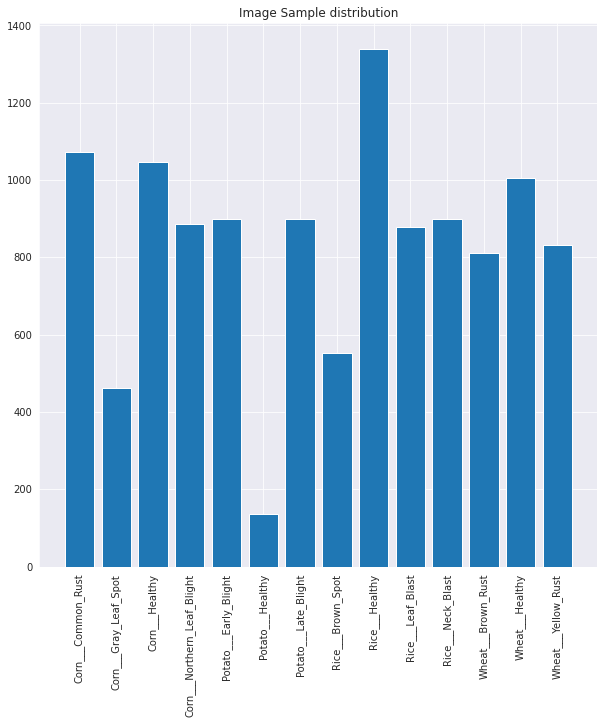

Rice___Healthy  has the most images=  1339   Potato___Healthy  has the least images=  137
average height=  685  average width=  574 aspect ratio=  1.1935848793901633


In [4]:
sdir=r'./BangladeshiCrops/Crop___Disease'
croplist=os.listdir(sdir)
filepaths = []
labels=[]
for crop in croplist:
    croppath=os.path.join(sdir,crop) 
    classlist=os.listdir(croppath)
    for klass in classlist:        
        classpath=os.path.join(croppath,klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels']) 
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
Catseries=pd.Series(classlist, name='Category')
Countseries=pd.Series(countlist, name='Image Count')
crop_df=pd.concat([Catseries, Countseries], axis=1)
print(crop_df.head(class_count))
fig = plt.figure(figsize=(10,10))
labels=crop_df['Category']
sizes=crop_df['Image Count']
x=np.arange(len(labels))
plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
plt.title('Image Sample distribution')
plt.bar(x,sizes, tick_label=crop_df['Category'])
plt.show()
# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

<a id="trim"></a>
# <center>Trim train_df so no class has more than 200 image samples</center>
Since each class has more than 150 images train_df will have class balance

In [5]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=200 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=137
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  137


<a id="balance"></a>
# <center>Balance the train_df dataframe</center>
The balance function takes a dataframe as an input. It generates and saves augmented images for  
each class so that each class will have the same number of images specified by the value n. The input  
dataframe is concatenated with the augmented images filepaths to provide a balanced dataset.

In [6]:
def balance(df, n, working_dir, img_size):
    def augment(df,n, working_dir, img_size):
        aug_dir=os.path.join(working_dir, 'aug')
        os.mkdir(aug_dir)        
        for label in df['labels'].unique():    
            dir_path=os.path.join(aug_dir,label)    
            os.mkdir(dir_path)
        # create and store the augmented images  
        total=0
        gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                      height_shift_range=.2, zoom_range=.2)
        groups=df.groupby('labels') # group by class
        for label in df['labels'].unique():  # for every class               
            group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
            sample_count=len(group)   # determine how many samples there are in this class  
            if sample_count< n: # if the class has less than target number of images
                aug_img_count=0
                delta=n - sample_count  # number of augmented images to create
                target_dir=os.path.join(aug_dir, label)  # define where to write the images
                msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
                print(msg, '\r', end='') # prints over on the same line
                aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                                class_mode=None, batch_size=1, shuffle=False, 
                                                save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                                save_format='jpg')
                while aug_img_count<delta:
                    images=next(aug_gen)            
                    aug_img_count += len(images)
                total +=aug_img_count
        print('Total Augmented images created= ', total)
        # create aug_df and merge with train_df to create composite training set ndf
        aug_fpaths=[]
        aug_labels=[]
        classlist=os.listdir(aug_dir)
        for klass in classlist:
            classpath=os.path.join(aug_dir, klass)     
            flist=os.listdir(classpath)    
            for f in flist:        
                fpath=os.path.join(classpath,f)         
                aug_fpaths.append(fpath)
                aug_labels.append(klass)
        Fseries=pd.Series(aug_fpaths, name='filepaths')
        Lseries=pd.Series(aug_labels, name='labels')
        aug_df=pd.concat([Fseries, Lseries], axis=1)         
        df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
        print('Length of augmented dataframe is now ', len(df))
        return df 
    
    df=df.copy() 
    print('Initial length of dataframe is ', len(df))
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')    
    if 'aug' in os.listdir(working_dir):
        print(' Augmented images already exist. To delete these and create new images enter D, else enter U to use these images', flush=True)
        ans=input(' ')
        if ans == 'D' or ans == 'd':            
            shutil.rmtree(aug_dir) # start with an clean empty directory  
            return augment(df,n, working_dir, img_size)
            
        else:
            return df
    else:
        return augment(df,n, working_dir, img_size)
        
        
   
n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,200) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2737
 Augmented images already exist. To delete these and create new images enter D, else enter U to use these images


  D


Found 137 validated image filenames.     for class        Potato___Healthy        creating  63   augmented images 
Total Augmented images created=  63
Length of augmented dataframe is now  2800


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [7]:

batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 2800 validated image filenames belonging to 14 classes.          for train generator 
Found 651 validated image filenames belonging to 14 classes.           for valid generator 
Found 652 validated image filenames belonging to 14 classes.           for test generator 
test batch size:  4   test steps:  163  number of classes :  14


<a id="show"></a>
# <center>Create a function to show example training images</center>

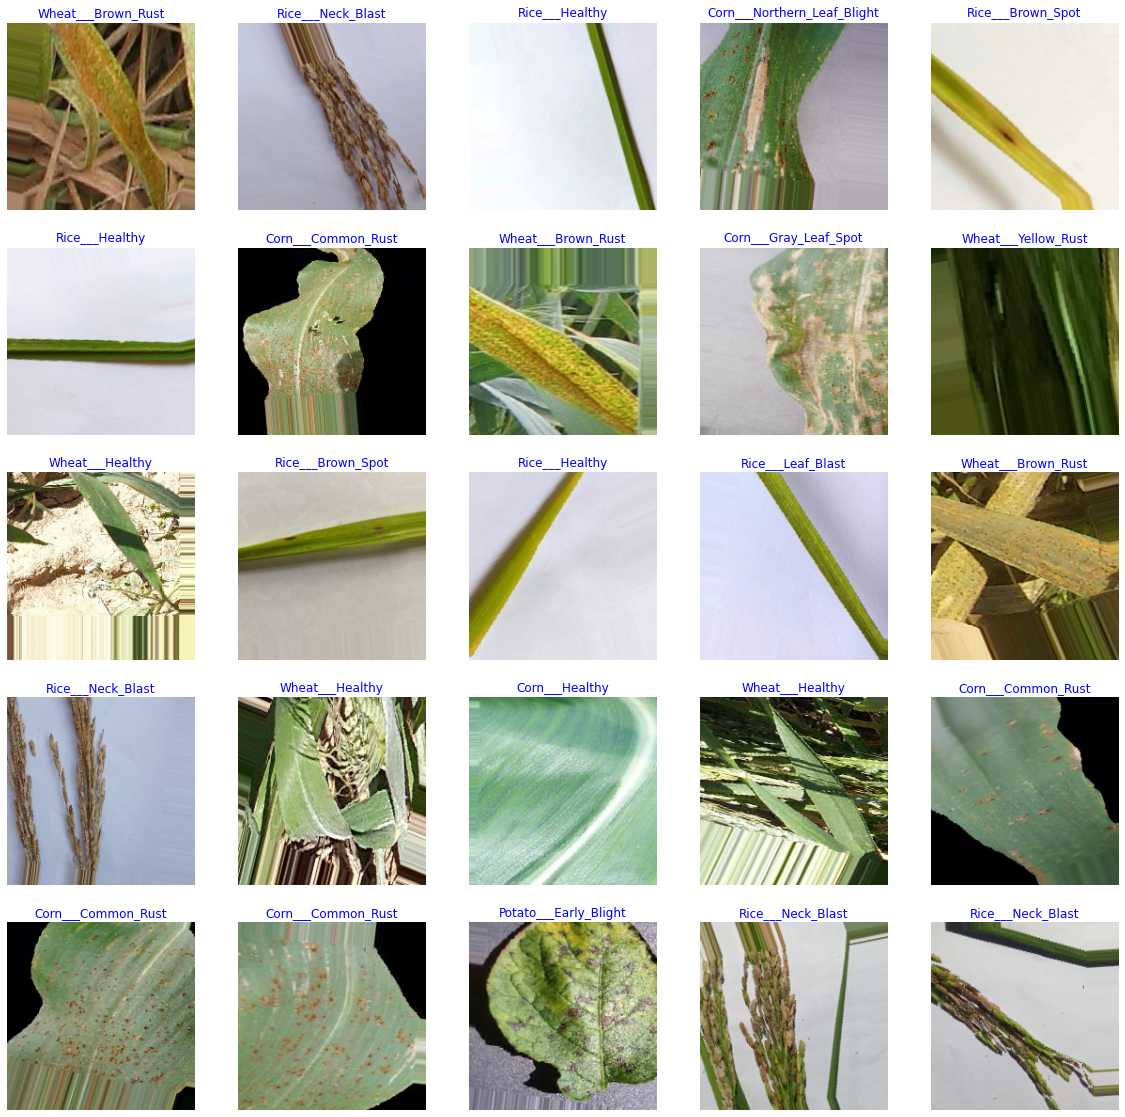

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable. Then train for some number of epochs
### then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs!

In [9]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.  
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [10]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print ('\n validation loss reduced, saving weights from epoch ', epoch + 1, ' as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print('current LR is ', lr,'  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print ('keeping current LR')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [11]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset
### It will converge faster and have a lower validation losss

In [12]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
94/94 [==============================] - ETA: 0s - loss: 8.0631 - accuracy: 0.6925
 validation loss reduced, saving weights from epoch  1  as best weights
94/94 [==============================] - 75s 597ms/step - loss: 8.0631 - accuracy: 0.6925 - val_loss: 7.1654 - val_accuracy: 0.7942
Epoch 2/40
94/94 [==============================] - ETA: 0s - loss: 6.0361 - accuracy: 0.8771
 validation loss reduced, saving weights from epoch  2  as best weights
94/94 [==============================] - 50s 528ms/step - loss: 6.0361 - accuracy: 0.8771 - val_loss: 5.4194 - val_accuracy: 0.9017
Epoch 3/40
94/94 [==============================] - ETA: 0s - loss: 4.7733 - accuracy: 0.9121
 validation loss reduced, saving weights from epoch  3  as best weights
94/94 [==============================] - 51s 537ms/step - loss: 4.7733 - accu

 15


you entered  15  Training will continue to epoch  20
current LR is  0.0010000000474974513   hit enter to keep  this LR or enter a new LR


keeping current LR
94/94 [==============================] - 212s 2s/step - loss: 3.0610 - accuracy: 0.9314 - val_loss: 2.6676 - val_accuracy: 0.9524
Epoch 6/40
94/94 [==============================] - ETA: 0s - loss: 2.4413 - accuracy: 0.9518
 validation loss reduced, saving weights from epoch  6  as best weights
94/94 [==============================] - 50s 532ms/step - loss: 2.4413 - accuracy: 0.9518 - val_loss: 2.1652 - val_accuracy: 0.9370
Epoch 7/40
94/94 [==============================] - ETA: 0s - loss: 1.9501 - accuracy: 0.9539
 validation loss reduced, saving weights from epoch  7  as best weights
94/94 [==============================] - 50s 532ms/step - loss: 1.9501 - accuracy: 0.9539 - val_loss: 1.7433 - val_accuracy: 0.9432
Epoch 8/40
94/94 [==============================] - ETA: 0s - loss: 1.5930 - accuracy: 0.9504
 validation loss reduced, saving weights from epoch  8  as best weights
94/94 [==============================] - 51s 534ms/step - loss: 1.5930 - accuracy: 0.9504

 20


you entered  20  Training will continue to epoch  40
current LR is  0.0010000000474974513   hit enter to keep  this LR or enter a new LR


keeping current LR
94/94 [==============================] - 174s 2s/step - loss: 0.3546 - accuracy: 0.9818 - val_loss: 0.4462 - val_accuracy: 0.9462
Epoch 21/40
94/94 [==============================] - ETA: 0s - loss: 0.3508 - accuracy: 0.9807
 validation loss reduced, saving weights from epoch  21  as best weights
94/94 [==============================] - 51s 539ms/step - loss: 0.3508 - accuracy: 0.9807 - val_loss: 0.4196 - val_accuracy: 0.9555
Epoch 22/40
94/94 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.9804
 validation loss reduced, saving weights from epoch  22  as best weights
94/94 [==============================] - 51s 543ms/step - loss: 0.3341 - accuracy: 0.9804 - val_loss: 0.3804 - val_accuracy: 0.9585
Epoch 23/40
94/94 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.9868
 validation loss reduced, saving weights from epoch  23  as best weights
94/94 [==============================] - 52s 548ms/step - loss: 0.3086 - accuracy: 

 H


you entered  H  Training halted on epoch  40  due to user input

94/94 [==============================] - 56s 595ms/step - loss: 0.2067 - accuracy: 0.9932 - val_loss: 0.3313 - val_accuracy: 0.9524
loading model with weights from epoch  34
training elapsed time was 0.0 hours, 39.0 minutes, 25.43 seconds)


<a id="plot"></a>
# <center>Define a function to plot the training data

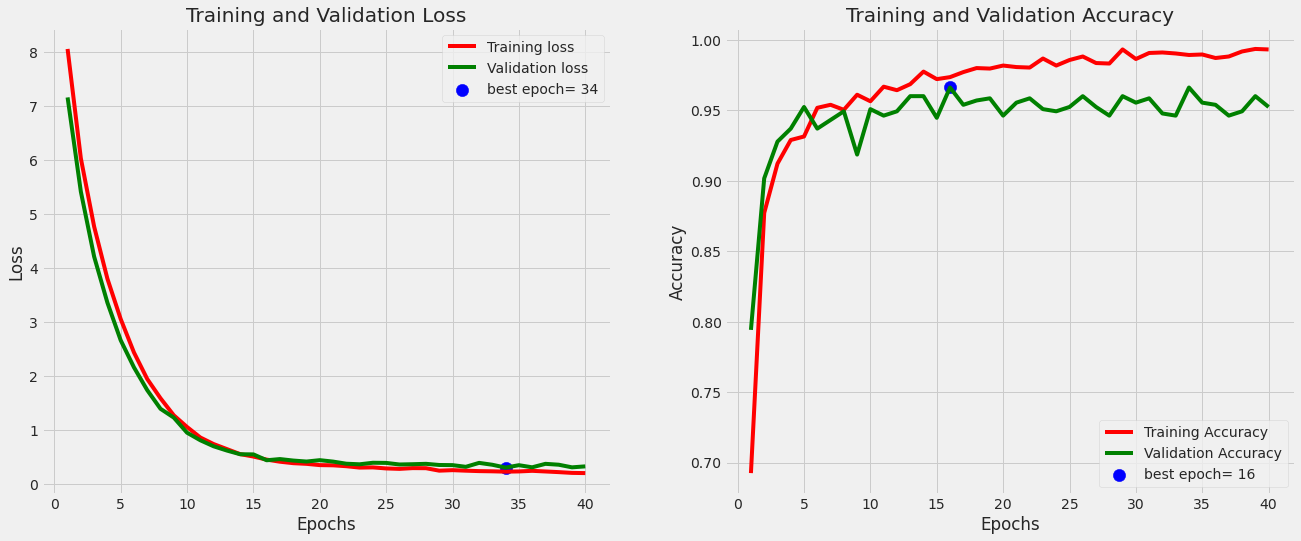

In [13]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

163/163 [==============================] - 10s 45ms/step
there were 24 errors in 652 tests for an accuracy of  96.32


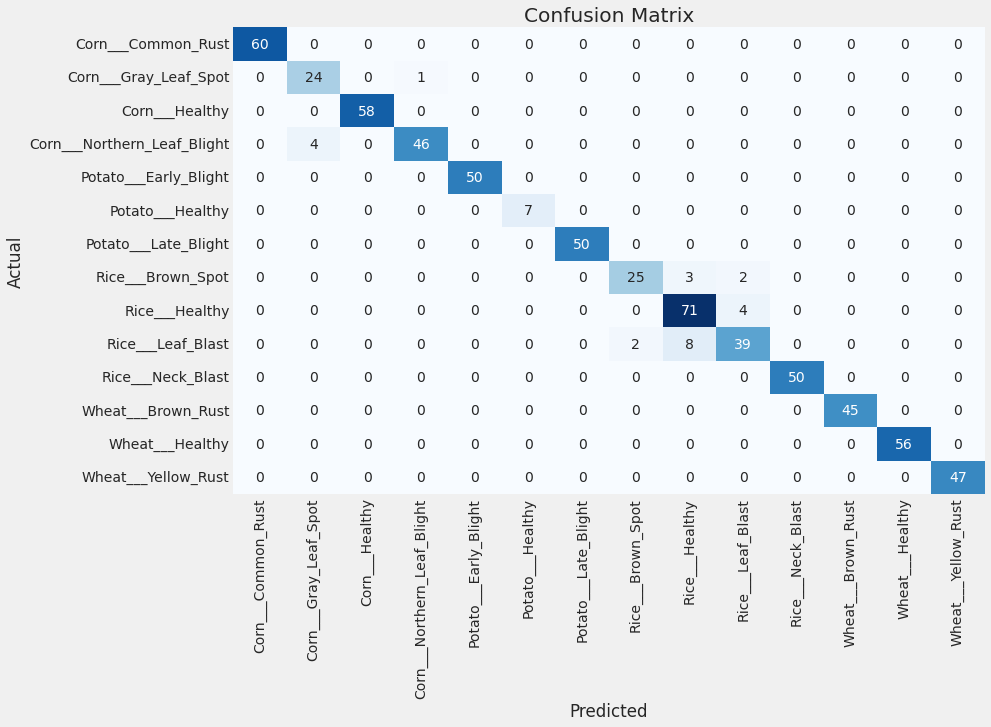

Classification Report:
----------------------
                              precision    recall  f1-score   support

         Corn___Common_Rust     1.0000    1.0000    1.0000        60
      Corn___Gray_Leaf_Spot     0.8571    0.9600    0.9057        25
             Corn___Healthy     1.0000    1.0000    1.0000        58
Corn___Northern_Leaf_Blight     0.9787    0.9200    0.9485        50
      Potato___Early_Blight     1.0000    1.0000    1.0000        50
           Potato___Healthy     1.0000    1.0000    1.0000         7
       Potato___Late_Blight     1.0000    1.0000    1.0000        50
          Rice___Brown_Spot     0.9259    0.8333    0.8772        30
             Rice___Healthy     0.8659    0.9467    0.9045        75
          Rice___Leaf_Blast     0.8667    0.7959    0.8298        49
          Rice___Neck_Blast     1.0000    1.0000    1.0000        50
         Wheat___Brown_Rust     1.0000    1.0000    1.0000        45
            Wheat___Healthy     1.0000    1.0000    1.0

In [14]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

<a id="save"></a>
# <center>Save the model

In [15]:
subject='crops' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc ) 
   

/opt/app-root/lib64/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


model was saved as  ./crops_96.31.h5
